In [2]:
import tensorflow as tf
from tensorflow import keras
import theano.tensor as T
import pymc3 as pm
import numpy as np
import seaborn as sns

In [3]:
tfmodel = keras.models.load_model('../test_grid_model.h5')

In [4]:
tfmodel.summary()

Model: "test_grid_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
outputs (Dense)              (None, 3)                 33        
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


In [5]:
weights_list = tfmodel.get_weights()

In [6]:
def nn(input):
    nh_layers = int(len(weights_list) / 2 - 2)
    xx = T.nnet.elu(pm.math.dot(input, weights_list[0]) + weights_list[1])
    for hl in range(1, 1+nh_layers):
        xx = T.nnet.elu(pm.math.dot(xx, weights_list[hl * 2]) + weights_list[hl * 2 + 1])
    xx = pm.math.dot(xx, weights_list[-2]) + weights_list[-1]
    return 10**(xx)

In [10]:
params = ['star_age', 'initial_mass']
obs = ['radius', 'effective_T', 'delta_nu']

In [11]:
nn([np.log10(4.5), np.log10(1.0)]).eval()

array([1.14267237e+00, 6.08204420e+03, 1.13291452e+02])

In [12]:
inputs = [np.log10(4.5), np.log10(1.0)]
outputs = nn(inputs).eval()

In [16]:
obs_unc = np.array([0.01, 70.0, 1.0])
obs_ = outputs + np.random.randn(len(outputs)) * obs_unc
print(obs_)

[1.14667196e+00 6.20130970e+03 1.13996384e+02]


In [17]:
model = pm.Model()

with model:
    mass = pm.Normal('mass', 1.0, 0.2)
    age = pm.Normal('age', 4.5, 1.0)
    
    obs_prop = pm.Deterministic('obs_prop', nn([np.log10(age), np.log10(mass)]))
    
    like = pm.Normal('like', obs_prop, obs_unc, observed=obs_, shape=3)

In [18]:
inits = ['adapt_diag']
start = {'mass': 1.01, 'age': 4.5}

with model:
    trace = pm.sample(tune=1000, init=inits[0], start=start, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, mass]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


/Users/davies/Library/Python/3.7/lib/python/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


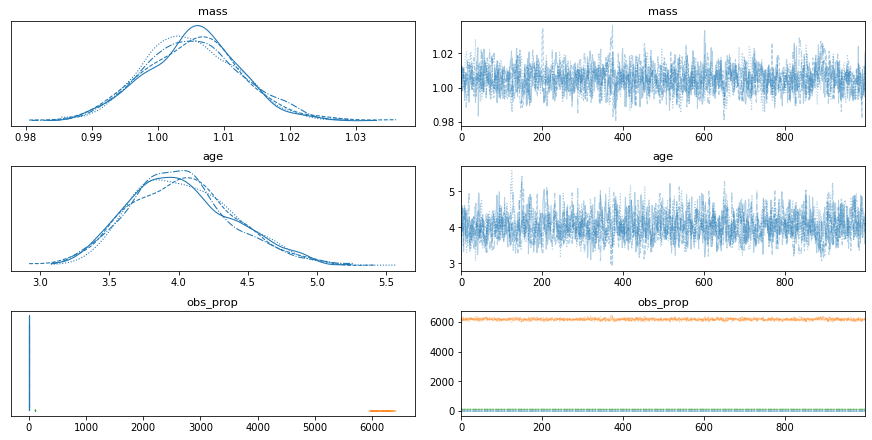

In [19]:
pm.traceplot(trace);

In [20]:
pm.summary(trace)

/Users/davies/Library/Python/3.7/lib/python/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mass,1.005,0.007,0.991,1.018,0.000,0.000,1117.0,1114.0,1126.0,1225.0,1.0
age,4.029,0.376,3.384,4.771,0.011,0.008,1102.0,1102.0,1091.0,1383.0,1.0
obs_prop[0],1.140,0.007,1.126,1.153,0.000,0.000,3735.0,3730.0,3735.0,2848.0,1.0
obs_prop[1],6164.567,67.316,6037.093,6287.015,2.036,1.441,1093.0,1092.0,1097.0,1383.0,1.0
obs_prop[2],113.333,0.744,111.930,114.683,0.015,0.011,2477.0,2477.0,2480.0,2677.0,1.0
